<a href="https://colab.research.google.com/github/IGieckI/BriscolAI/blob/main/BriscolAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from enum import Enum
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [37]:
# Cell not related to the project itself, but to check the GPU availability
import tensorflow as tf
import os
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# An AI model trained with reinforcement learning to play with Cactus 🥱
# Look at the future reward management in the training

2.10.0
Num GPUs Available:  1


In [38]:
class Card:
    """
        Game card class
    """

    def __init__(self, rank: int, seed: int):
        self.rank = int(rank)
        self.seed = int(seed)

    def __str__(self):
        return f"{self.get_rank()} of {self.get_seed()}"

    def __hash__(self):
        return self.seed * 10 + self.rank

    def get_value(self) -> int:
        """
        Get the point value of the card based on its rank
        """
        point_values = {
            0: 11,
            1: 0,
            2: 10,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 2,
            8: 3,
            9: 4,
        }
        return point_values.get(self.rank)

    def get_value_from_hash(hash) -> int:
        """
        Get the point value of the card based on its rank from hash
        """
        point_values = {
            0: 11,
            1: 0,
            2: 10,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 2,
            8: 3,
            9: 4,
        }

        return point_values[hash%10]

    def get_rank(self) -> str:
        """
        Get the rank of the card as string
        """
        ranks = {
            0: "Ace",
            1: "Two",
            2: "Three",
            3: "Four",
            4: "Five",
            5: "Six",
            6: "Seven",
            7: "Knave",
            8: "Knight",
            9: "King"
        }

        return ranks.get(self.rank)

    def get_seed(self) -> str:
        """
        Get the seed of the card as string
        """
        seeds = {
            0: "Cups",
            1: "Denari",
            2: "Swords",
            3: "Sticks"
        }

        return seeds.get(self.seed)

    def compare_cards(self, other_card: 'Card') -> 'Card':
        """
        Compare two cards to determine the winner ONLY based on their ranks NOT the seed

        Args:
            other_card : Card, The other card to compare

        Returns:
            Card: The winner card
        """
        if self.get_point_value() > other_card.get_point_value():
            return self
        else:
            return other_card

class CardState(Enum):
    NOT_IN_GAME_YET = 0
    BRISCOLA = 1
    IN_P1_HAND = 2
    IN_P2_HAND = 3
    PLAYED = 4
    PLAYED_IN_PREVIOUS_TURNS = 5

In [39]:
class Agent():
    """
        BriscolAI default Agent
    """

    def __init__(self, gamma: float, memory_limit: int = 1000):
        # Define hyper-parameters
        self.gamma = gamma
        
        def create_model():
            model = keras.Sequential(
                [
                    layers.Input(shape=(40, 40)),
                    layers.Flatten(),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(units=3, activation='softmax')
                ]
            )
            
            # !!! TRY ALSO MSE LOSS !!!            
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            
            return model

        # Create the action and target network
        self.action_model = create_model()
        
        self.target_model = create_model()
        self.target_model.set_weights(self.action_model.get_weights())

        # Create the state
        self.previous_state = None
        self.state = None

        # Create the memory of states
        self.memory = np.array([])
        self.memory_limit = memory_limit

    def set_state(self, state: np.ndarray):
        """
            Set the new state and automatically the previous state
        """
        self.previous_state = self.state
        if self.state is None:
            self.previous_state = state

        self.state = state

    def get_state(self) -> np.ndarray:
        return np.copy(self.state)

    def get_previous_state(self) -> np.ndarray:
        return self.previous_state

    def get_action(self) -> int:
        return np.argmax(self.action_model.predict(self.state.reshape(-1, 40, 40), verbose=0)[0])

    def save_in_memory(self, game_id: int, player: int, state: np.ndarray, action: int, reward: int, new_state: np.ndarray, done: bool):
        if len(self.memory) >= self.memory_limit:
            self.memory = self.memory[int(self.memory_limit / 2):]

        self.memory = np.append(self.memory, {
            "game_id": game_id,
            "player": player,
            "current_state": state,
            "action":action,
            "reward":reward,
            "next_state":new_state,
            "done" :done
        })

    def train(self, batch_size: int = 30):
        # Choose a batch of random samples for training
        random_indices = np.random.choice(len(self.memory), size=batch_size, replace=False)
        batch_sample = self.memory[random_indices]
        self.memory = np.delete(self.memory, random_indices)


        q_target_values = []

        # Train the network over the batch
        for i, experience in enumerate(batch_sample):
            q_target_value = self.target_model.predict(experience["current_state"].reshape(1, 40, 40), verbose=0)            
            q_action_value = self.action_model.predict(experience["current_state"].reshape(1, 40, 40), verbose=0)
            
            q_target_values.append(q_target_value)

            if not experience["done"]:
                target_value = experience["reward"] + self.gamma * np.amax(q_target_value)
            else:
                target_value = experience["reward"]
            q_action_value[experience["action"]] = target_value
            
        self.action_model.train_on_batch(batch_sample["current_state"], q_action_values)

In [40]:
class Briscola():
    def __init__(self):
        self.reset()

    def __str__(self):
        out = f'''Cards in the deck: {len(self.deck) + 1} \nBriscola: {self.briscola_card} \nPlayed Card: {self.played_card}\n\n'''

        out += 'Your hand:\n'
        for x, i in enumerate(self.p2_hand):
            out += f'{x}) {i}\n'

        return out

    def get_P1_state(self) -> np.ndarray:
        p1_state = np.copy(self.state)
        p1_state[p1_state == CardState.IN_P2_HAND.value] = CardState.NOT_IN_GAME_YET.value
        return p1_state

    def get_P2_state(self) -> np.ndarray:
        p2_state = np.copy(self.state)
        p2_state[p2_state == CardState.IN_P1_HAND.value] = CardState.NOT_IN_GAME_YET.value
        return p2_state

    def print_state(state):
        # Utility function to save a state as scv
        df = pd.DataFrame(state)
        df.to_csv('data.csv', index=False)

    def draw_card(self) -> Card:
        """
        Each player draw from the deck taking out cards from the deck list
        """
        if len(self.deck) == 0:
            self.briscola_drawn = True
            return self.briscola_card

        if len(self.deck) == 0:
            return []

        return self.deck.pop(0)

    def create_deck(self) -> list[Card]:
        """
        Create a new deck with cards in random position
        """
        deck = [Card(rank, seed) for rank in np.arange(0,10) for seed in np.arange(0,4)]
        np.random.shuffle(deck)

        return deck

    def fight(self, first_card: Card, second_card: Card):
        """
        Tells who win between the two cards

        Args:
            first_card : Card, first card played
            second_card : Card, second card played

        Returns:
            Card : The winner Card
        """

        if first_card.seed == second_card.seed:
            return first_card.compare_cards(second_card)

        if first_card.seed == self.briscola_card.seed:
            return first_card

        if second_card.seed == self.briscola_card.seed:
            return second_card

        return first_card

    def fight_hash(self, first_card_hash: int, second_card_hash: int):
        """
        Tells who win between the two cards

        Args:
            first_card_hash : First card played's hash
            second_card_hash : Second card played's hash

        Returns:
            Card : The winner Card's hash
        """

        if first_card_hash//10 == second_card_hash//10:
            power = {
                0: 9, # Ace
                1: 0, # Two
                2: 8, # Three
                3: 1, # Four
                4: 2, # Five
                5: 3, # Six
                6: 4, # Seven
                7: 5, # Knave
                8: 6, # Knight
                9: 7  # King
            }
            return power[first_card_hash%10] > power[second_card_hash%10]

        if first_card_hash//10 == self.briscola_card.seed:
            return first_card_hash

        if second_card_hash//10 == self.briscola_card.seed:
            return second_card_hash

        return first_card_hash

    def reset(self, ai_turn: bool = None):
        """Reset the current environement"""

        # Create a deck and give cards to each player
        self.deck = self.create_deck()

        self.p1_hand = []
        self.p2_hand = []

        self.p1_hand.append(self.draw_card())
        self.p1_hand.append(self.draw_card())
        self.p1_hand.append(self.draw_card())

        self.p2_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())

        # Choose the briscola of the game and set a variable to check if the briscola (last card of the game) was drawn
        self.briscola_card = self.draw_card()
        self.briscola_drawn = False

        # Initialize the scores
        self.p1_score, self.p2_score = 0, 0

        # Choose who start
        self.turn = np.random.randint(0, 1) if ai_turn is None else int(ai_turn)
        self.turn_number = 0

        # Create the state to be given to the network
        self.state = np.full((40,40), CardState.NOT_IN_GAME_YET.value)
        self.state[hash(self.briscola_card), :] = CardState.BRISCOLA.value

        for x in self.p1_hand:
            self.state[hash(x), 0] = CardState.IN_P1_HAND.value
        for x in self.p2_hand:
            self.state[hash(x), 0] = CardState.IN_P2_HAND.value

        # Last turn played card (if there is a card on the field, helping variable to save complexity later)
        self.played_card = None
        self.episode_ended = False

        return

    def step(self, action: int):
        """Apply action and return new time_step."""

        # Determine if the player choose a card number he don't have in the hand
        if action < 0 or (self.turn == 0 and action >= len(self.p1_hand)) or (self.turn == 1 and action >= len(self.p2_hand)):
            return self.state, -10000, False

        # Each turn at the beginning is a copy of the previous turn
        if self.turn_number > 0:
            self.state[:, self.turn_number] = self.state[:, self.turn_number - 1]

        chosen_card = self.p1_hand[action] if self.turn == 0 else self.p2_hand[action]

        # Setup reward variable with model training purpose only, will be 0 if currently playing the first card on the table
        reward = 0

        # Id of the winner
        winner = (self.turn + 1) % 2

        # Determine if the turn player played the first card or is a reply to a played card
        if self.turn_number % 2 == 0:
            # Update the previous turn PLAYED cards into PLAYED_IN_PREVIOUS_TURNS cards
            self.state[self.state[:, self.turn_number] == CardState.PLAYED.value, self.turn_number] = CardState.PLAYED_IN_PREVIOUS_TURNS.value
            self.played_card = chosen_card
        else:
            # Determine the winner and assign round_points
            winner = self.turn if self.fight_hash(hash(self.played_card), hash(chosen_card)) == hash(chosen_card) else (self.turn + 1) % 2
            reward = Card.get_value_from_hash(hash(chosen_card)) + Card.get_value_from_hash(hash(self.played_card))

        # Set played the chosen card
        self.state[hash(chosen_card), self.turn_number] = CardState.PLAYED.value

        if self.turn_number % 2 != 0:
            # Update scores, assign rewards and draw cards
            if winner == 0:
                self.p1_score += reward

                if not self.briscola_drawn:
                    self.p1_hand.append(self.draw_card())
                    self.p2_hand.append(self.draw_card())
            else:
                self.p2_score += reward

                if not self.briscola_drawn:
                    self.p2_hand.append(self.draw_card())
                    self.p1_hand.append(self.draw_card())

            # Update the state with both of the drew cards (only if a card is drawn)
            if not self.briscola_drawn:
                self.state[hash(self.p1_hand[-1]), self.turn_number] = CardState.IN_P1_HAND.value
                self.state[hash(self.p2_hand[-1]), self.turn_number] = CardState.IN_P2_HAND.value

            # Reset for next round
            self.played_card = None

        # Remove the used card
        self.p1_hand.pop(action) if self.turn == 0 else self.p2_hand.pop(action)

        # Switch turns
        self.turn_number+=1
        if winner != self.turn:
            self.turn += 1
            self.turn %= 2

        # Check for game termination
        self.episode_ended = (len(self.p1_hand) == 0 and len(self.p2_hand) == 0)

        # Return the time step
        return self.state, reward, self.episode_ended

    def is_playing(self):
        return not self.episode_ended

    def get_winner(self):
        if self.p1_score > self.p2_score:
            return 0
        elif self.p2_score > self.p1_score:
            return 1
        return 2

In [41]:
# Training parameters
total_episodes = 5000        # Total episodes
learning_rate = 0.1           # Learning rate
gamma = 0.99                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
epsilon_max = 1.0             # Exploration probability at start
epsilon_min = 0.01            # Minimum exploration probability
epsilon_decay = 0.001         # Exponential decay rate for exploration prob
precalc_epsilon_dacay = np.exp(-epsilon_decay) # Pre-calculate the decay

# System parameters
memory_limit = 500           # Memory limit for the agent
saving_rate = 100            # Saving rate for the model (each X episodes)

In [42]:
# List of rewards to write a graph representation of the improvements
rewards = []
briscolAI = Agent(gamma, memory_limit)

for episode in range(1, total_episodes):
    print(f"Episode: {episode}/{total_episodes} | Epsilon: {epsilon}")

    # Reset the environment
    game = Briscola()

    while game.is_playing():
        briscolAI.set_state(game.get_P1_state() if game.turn == 0 else game.get_P2_state())

        # If the random si greater than epsilon i'll take the biggest Q value for this state otherwise a random one
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, len(game.p1_hand if game.turn == 0 else game.p2_hand))
        else:
            action = briscolAI.get_action()

        new_state, reward, episode_ended = game.step(action)

        # Note: Here the game.turn check is reversed since during the game.step() turn change happen, but for the memory logic is "not good"
        briscolAI.set_state(game.get_P1_state() if game.turn == 1 else game.get_P2_state())

        # Add the memory to the replay buffer
        briscolAI.save_in_memory(episode, game.turn, briscolAI.get_previous_state(), action, reward, briscolAI.get_state(), not game.is_playing())

    # Update the rewards on the played actions during the last game
    last_session_id = briscolAI.memory[-1]["game_id"]
    winning_player = game.get_winner()
    score_difference = 0

    if winning_player != 2:
        winning_score = game.p1_score - game.p2_score if winning_player == 0 else game.p2_score - game.p1_score

    for sample_id in range(len(briscolAI.memory)):
        sample = briscolAI.memory[-sample_id]
        if sample["game_id"] != last_session_id or winning_player == 2:
            break
        before = sample["reward"]
        if sample["player"] == winning_player:
            sample["reward"] += winning_score
        else:
            sample["reward"] -= winning_score

    print(f"Winner: {winning_player}, last ses id: {last_session_id} score: {winning_score}")
    print(f"Score p1: {game.p1_score}, Score p2: {game.p2_score}")

    # Train the network over the memory
    briscolAI.train()

    # Save current state of the model
    if episode % saving_rate == 0:
        briscolAI.model.save('model.h5')

    # Reduce of the espsilon factor
    epsilon *= precalc_epsilon_dacay
    if (epsilon <= epsilon_min):
        epsilon = epsilon_min

    rewards.append(abs(game.p1_score - game.p2_score))

Episode: 1/5000 | Epsilon: 1.0
Winner: 0, last ses id: 1 score: 16
Score p1: 68, Score p2: 52


IndexError: index 2 is out of bounds for axis 0 with size 1

Average score difference over time: 10.5236


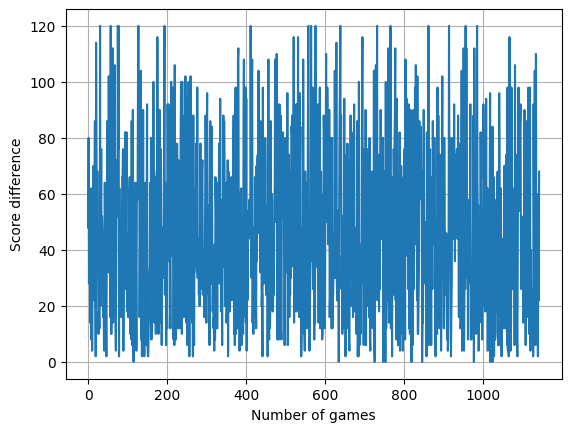

In [ ]:
# Print results data
print ("Average score difference over time: " +  str(sum(rewards)/total_episodes))

plt.plot(rewards)
plt.xlabel('Number of games')
plt.ylabel('Score difference')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import output

# Play the game
game = Briscola()

# choose who play first
if np.random.uniform(0, 1) < 0.5:
    ai_turn = True
else:
    ai_turn = False

game.reset(ai_turn)

# start game
while game.is_playing():
    print("---------------------------------------------")
    print(game)

    # Variables to display the fight text 5 lines after
    previous_played_card = game.played_card

    if ai_turn:
        print("Player turn:")
        print(f"Select the card by entering the index (ex:\"0\" -> to select {game.p2_hand[0]}):")
        action = int(input())   # CHECK THE INT TYPE !!!
        current_played_card = game.p2_hand[action]
        if action < 0 or action > len(game.p2_hand) - 1:
            continue
        print(f"Player played {current_played_card}\n")
        new_state, reward, episode_ended = game.step(action)
    else:
        print("BriscolAI turn:")
        action = np.random.randint(0, len(game.p1_hand))
        current_played_card = game.p1_hand[action]
        print(f"BriscolAI played {current_played_card}\n")
        new_state, reward, episode_ended = game.step(action)
    print(f"Game turn: {game.turn_number}")

    if game.turn_number % 2 == 0:
        # Human did last turn
        if game.turn == 0:
            print(f"BriscolAI took {previous_played_card} with {current_played_card}")
        else:
            print(f"Human took {previous_played_card} with {current_played_card}")

    ai_turn = not ai_turn
    output.clear()

print(game)
winner = game.check_winner()

if winner == ' ':
    print("It's a draw!")
elif winner == "BriscolAI":
    print("You lost!")
else:
    print("You won!")